In [0]:
#unzipping here in colab session
#!unzip '/content/drive/My Drive/MonuSeg-20200317T123814Z-001.zip'

In [0]:
#%tensorflow_version 1.x
#%reset

In [0]:
#keras version 2.2.3
#!pip uninstall keras
#!pip install keras==2.2.3

In [190]:
#%reset
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

1.15.0
2.2.3


In [0]:
#Dataset MonuSeg
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

#import tensorflow as tf

#from keras.models import Model, load_model
#from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from keras.layers.core import Lambda, RepeatVector, Reshape
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
# Set some parameters
im_width = 512
im_height = 512
depth = 1
#border = 5

In [193]:
# list of names all images in the given path
ids_train = next(os.walk("./MonuSeg/Training/TissueImages"))[2]
print("No. of images in training set= ", len(ids_train))

# list of names all images in the given path
ids_test = next(os.walk("./MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(ids_test))

No. of images in training set=  30
No. of images in testing set =  14


In [0]:
#train
X_train = np.zeros((len(ids_train), im_height, im_width, depth ), dtype=np.float32)
y_train = np.zeros((len(ids_train), im_height, im_width, depth), dtype=np.float32)

#test
X_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)

In [195]:
X_train.shape

(30, 512, 512, 1)

In [196]:
#train

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+d[1]
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0
    
    
    
#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+"png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


6
True


Text(0.5, 1.0, 'Mask')

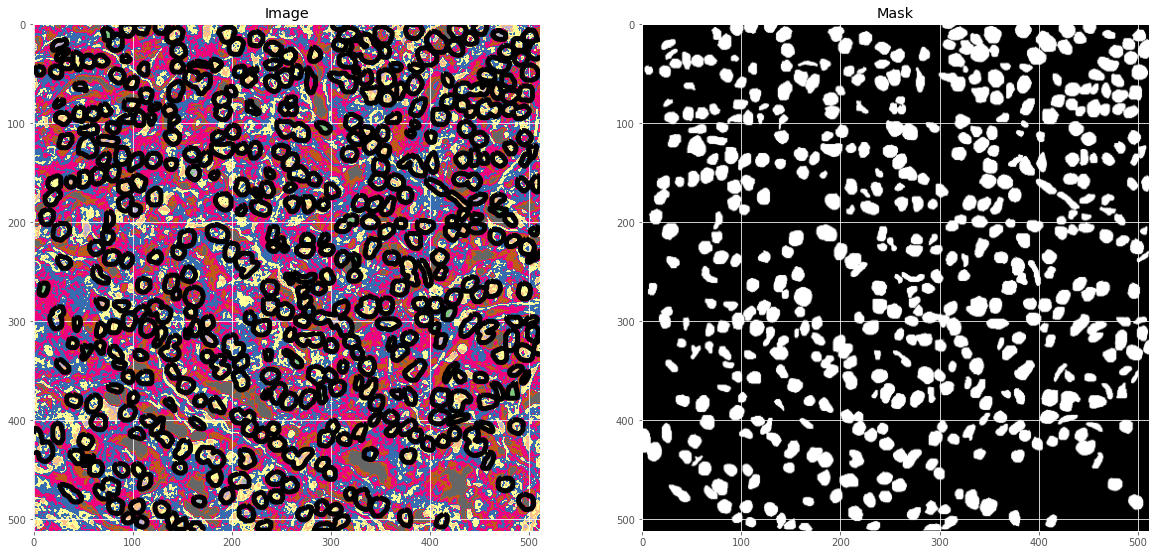

In [197]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train)-1)
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator
print(has_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'Accent', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')


In [0]:
#metrics
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D


def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build encoder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    #old
    #conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    #conv_26 = BatchNormalization()(conv_26)
    #conv_26 = Reshape(
    #        (input_shape[0]*input_shape[1], n_labels),
    #        input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

    #outputs = Activation(output_mode)(conv_25)
    print("Build decoder done..")

    #conv = Conv2D(1,(1, 1),strides=(1, 1), padding='same')(block10)
    #conv_reshape = Reshape((512*512,1))(conv)
    #outputs = Activation('softmax')(block10)
    outputs = Convolution2D(1, (1, 1), activation='sigmoid')(conv_25)

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [201]:
#input_img = Input((im_height, im_width, 1), name='img')
model = segnet(input_shape=(im_height, im_width, depth),n_labels=1)
print(model.summary())
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy',dice_coef]) 

Build encoder done..
Build decoder done..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_483 (Conv2D)             (None, 512, 512, 64) 640         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_477 (BatchN (None, 512, 512, 64) 256         conv2d_483[0][0]                 
__________________________________________________________________________________________________
activation_477 (Activation)     (None, 512, 512, 64) 0           batch_normalization_477[0][0]    
___________________________________________________________________

In [0]:
callbacks = [
    #EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-monuseg-SegNet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
#!rm /content/model-monuseg-SegNet.h5

In [205]:
results = model.fit(X_train, y_train, batch_size=1, epochs=50, callbacks=callbacks,
                    validation_data=(X_test, y_test))

Train on 30 samples, validate on 14 samples
Epoch 1/50
30/30 [==============================] - 30s 989ms/step - loss: 0.5323 - acc: 0.5825 - dice_coef: 0.4207 - val_loss: 3.2720 - val_acc: 0.6742 - val_dice_coef: 0.1863

Epoch 00001: val_loss improved from inf to 3.27196, saving model to model-monuseg-SegNet.h5
Epoch 2/50
30/30 [==============================] - 12s 394ms/step - loss: 0.3689 - acc: 0.6631 - dice_coef: 0.5516 - val_loss: 3.2852 - val_acc: 0.6621 - val_dice_coef: 0.3519

Epoch 00002: val_loss did not improve from 3.27196
Epoch 3/50
30/30 [==============================] - 12s 395ms/step - loss: 0.3532 - acc: 0.6696 - dice_coef: 0.5786 - val_loss: 3.0024 - val_acc: 0.6858 - val_dice_coef: 0.1721

Epoch 00003: val_loss improved from 3.27196 to 3.00237, saving model to model-monuseg-SegNet.h5
Epoch 4/50
30/30 [==============================] - 12s 395ms/step - loss: 0.3452 - acc: 0.6689 - dice_coef: 0.5856 - val_loss: 2.3867 - val_acc: 0.6555 - val_dice_coef: 0.4623

Epoch

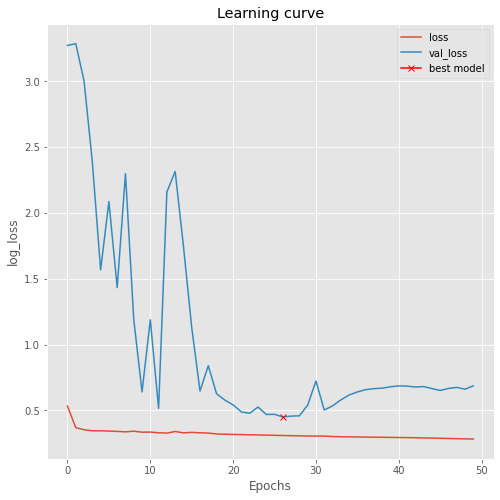

In [206]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

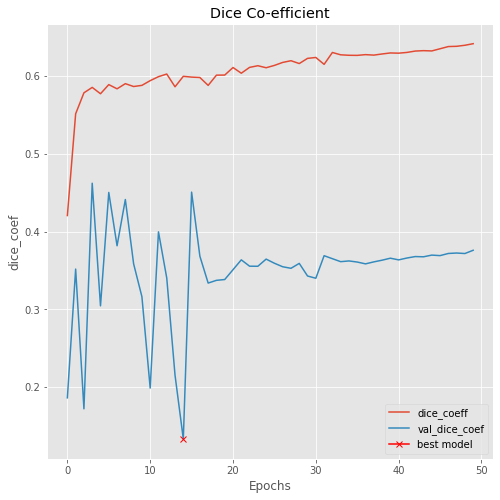

In [207]:
plt.figure(figsize=(8, 8))
plt.title("Dice Co-efficient")
plt.plot(results.history['dice_coef'], label="dice_coeff")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-monuseg-SegNet.h5')

In [209]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

14/14 [==============================] - 5s 345ms/step


[0.45003029704093933, 0.6832379102706909, 0.35486462712287903]

In [210]:
# Predict on train, val and test
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 7s 515ms/step


In [0]:
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

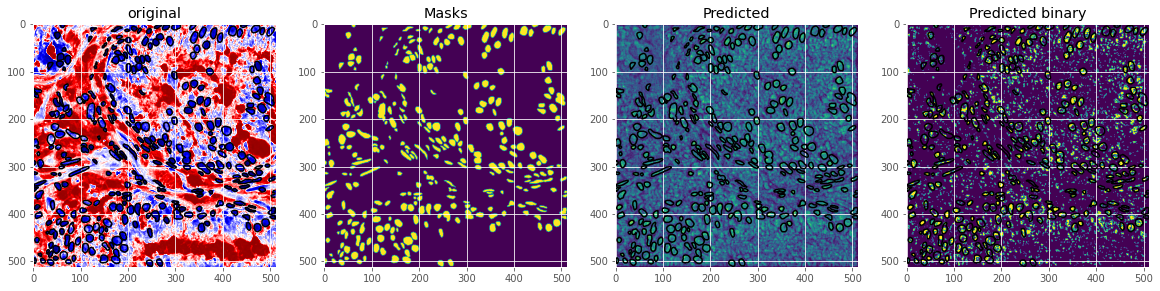

In [213]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=9)

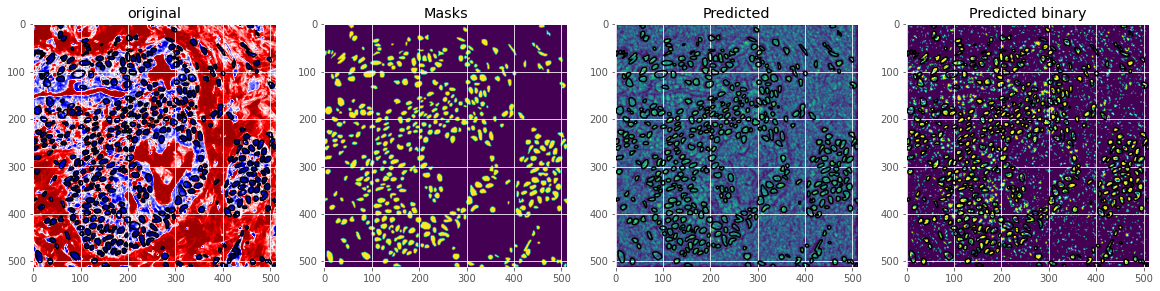

In [214]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=6)